# Prerequisites

To run this notebook, `tensorflow` and `microfaune` need to be installed.

To train or check prediction results, the datasets *freefield* and *warblr* must be unzipped in a folder (its path is specified in the next cell).
The folder tree should look like this:
* [data_dir_path]/
  * ff1010bird_wav/
    * labels.csv
    * wav/
  * warblrb10k_public_wav/
    * labels.csv
    * wav/


In [1]:
train = True
fineTuning = True
datasets_dir = "C:\\Users\\pc\\Documents\\BirdData"

# imports and function definitions

In [2]:
%matplotlib notebook
import os
import csv
import pickle
from collections import Counter
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.contrib.layers import group_norm
from tensorflow.math import reduce_max

from microfaune.audio import wav2spc
from glob import glob

C:\Users\pc\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pc\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pc\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pc\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework

In [3]:
def load_dataset(data_path, use_dump=True):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    else:
        dataset = compute_feature(data_path)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, "labels.csv")
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"))
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

In [4]:
def split_dataset(X, Y, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

# Load dataset

In [5]:
X0, Y0, uids0 = load_dataset(os.path.join(datasets_dir, "ff1010bird_wav"))
X1, Y1, uids1 = load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))
X2, Y2, uids2 = load_dataset(os.path.join(datasets_dir, "dsst"))
X3, Y3, uids3 = load_dataset(os.path.join(datasets_dir, "trimed"))
print(X0.shape, X1.shape, X2.shape, X3.shape)
print(Y0.shape, Y1.shape, Y2.shape, Y3.shape)
X = np.concatenate([X2, X3]).astype(np.float32)/255
Y = np.concatenate([Y2, Y3])
uids = np.concatenate([uids2, uids3])
# X = np.array(X3).astype(np.float32)/255
# Y = np.array(Y3)
# uids = np.array(uids3)
print(X.shape, Y.shape, uids.shape)

(7690, 431, 40) (445, 431, 40) (65, 431, 40) (228, 431, 40)
(7690,) (445,) (65,) (228,)
(293, 431, 40) (293,) (293,)


In [6]:
del X0, X1, Y0, Y1, X2, Y2, X3, Y3

In [7]:
Counter(Y)

Counter({0: 200, 1: 93})

In [8]:
ind_train, ind_test = split_dataset(X, Y)

X_train, X_test = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis]
Y_train, Y_test = Y[ind_train], Y[ind_test]
uids_train, uids_test = uids[ind_train], uids[ind_test]
del X, Y

In [9]:
print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))

Training set:  Counter({0: 160, 1: 74})
Test set:  Counter({0: 40, 1: 19})


# Create model 

In [10]:
n_filter = 64
conv_reg = keras.regularizers.l2(1e-3)
norm = "batch"

spec = layers.Input(shape=[*X_train.shape[1:]], dtype=np.float32)

x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(spec)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.MaxPool2D((1, 2))(x)

x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.MaxPool2D((1, 2))(x)

x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.Conv2D(n_filter, (3, 3), padding="same", kernel_regularizer=conv_reg, activation=None)(x)
if norm == "batch":
    x = layers.BatchNormalization(momentum=0.95)(x)
elif norm == "group":
    x = group_norm(x, groups=4, channels_axis=-1, reduction_axes=[-3, -2])
x = layers.ReLU()(x)
x = layers.MaxPool2D((1, 2))(x)

x = reduce_max(x, axis=-2)

x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)

x = layers.TimeDistributed(layers.Dense(64, activation="sigmoid"))(x)
local_pred = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"))(x)
pred = reduce_max(local_pred, axis=-2)

model = keras.Model(inputs=spec, outputs=pred)
model.summary()

# for predictions only
dual_model = keras.Model(inputs=spec, outputs=[pred, local_pred])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 431, 40, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 431, 40, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 431, 40, 64)       256       
___________________________________________________

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32):
        self.X = X
        self.Y = Y
        self.n = len(Y)
        self.batch_size = batch_size
        self.shuffle()
        
    def __len__(self):
        return int(np.floor(self.n)/self.batch_size)
    
    def __getitem__(self, index):
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
        return self.X[batch_inds, ...], self.Y[batch_inds]
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0

In [12]:
if train:
    if fineTuning:
        model.load_weights("model_weights-20190919_220113.h5")
    optimizer = keras.optimizers.Adam(lr=0.0001) #origin:0.001
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.FalseNegatives()])

    alpha = 0.4
    batch_size = 32

    data_generator = DataGenerator(X_train, Y_train, batch_size)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = keras.callbacks.ModelCheckpoint(filepath='best_model_weights.h5', save_weights_only=True, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=1e-5)

    history = model.fit_generator(data_generator, steps_per_epoch=5, epochs=100, 
                                  validation_data=(X_test, Y_test),
                                  class_weight={0: alpha, 1: 1-alpha},
                                  callbacks=[es,mc,reduce_lr], verbose=1) #origin steps_per_epoch=100, epochs=100

    date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    model.save_weights(f"model_weights-{date_str}.h5")
    

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/5 [=======================>......] - ETA: 4s - loss: 0.2937 - acc: 0.7422 - false_negatives: 17.0000
Epoch 00001: val_acc improved from -inf to 0.67797, saving model to best_model_weights.h5
5/5 [==============================] - 23s 5s/step - loss: 0.3005 - acc: 0.7500 - false_negatives: 21.0000 - val_loss: 0.9532 - val_acc: 0.6780 - val_false_negatives: 19.0000
Epoch 2/100
4/5 [=======================>......] - ETA: 3s - loss: 0.2092 - acc: 0.8047 - false_negatives: 11.0000
Epoch 00002: val_acc improved from 0.67797 to 0.79661, saving model to best_model_weights.h5
5/5 [==============================] - 18s 4s/step - loss: 0.2154 - acc: 0.8125 - false_negatives: 15.0000 - val_loss: 0.4185 - val_acc: 0.7966 - val_false_negatives: 11.0000
Epoch 3/100
4/5 [=======================>......] - ETA: 3s - loss: 0.1968 - acc: 0.8438 - false_negatives: 7.0000
Epoch 00003: val_acc improved

<IPython.core.display.Javascript object>


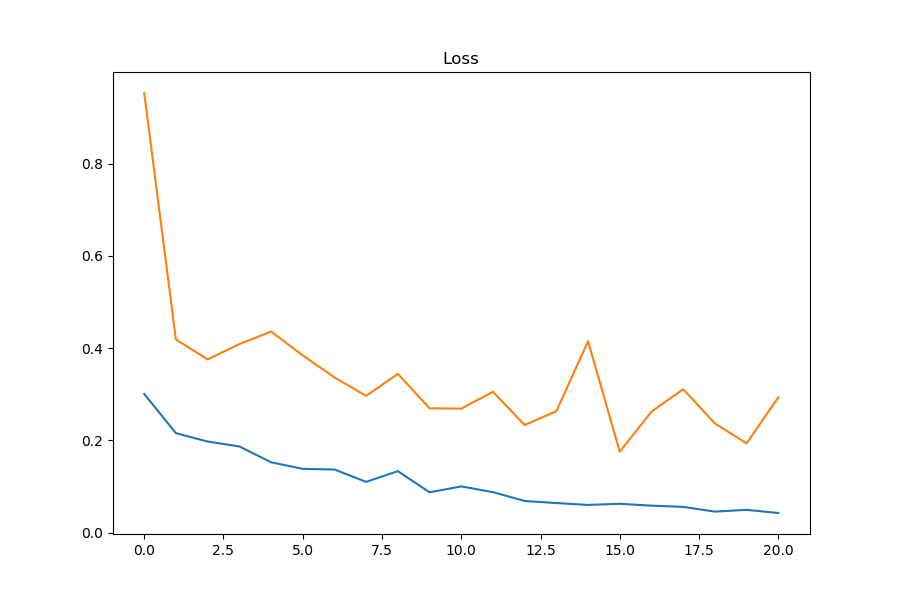

<IPython.core.display.Javascript object>


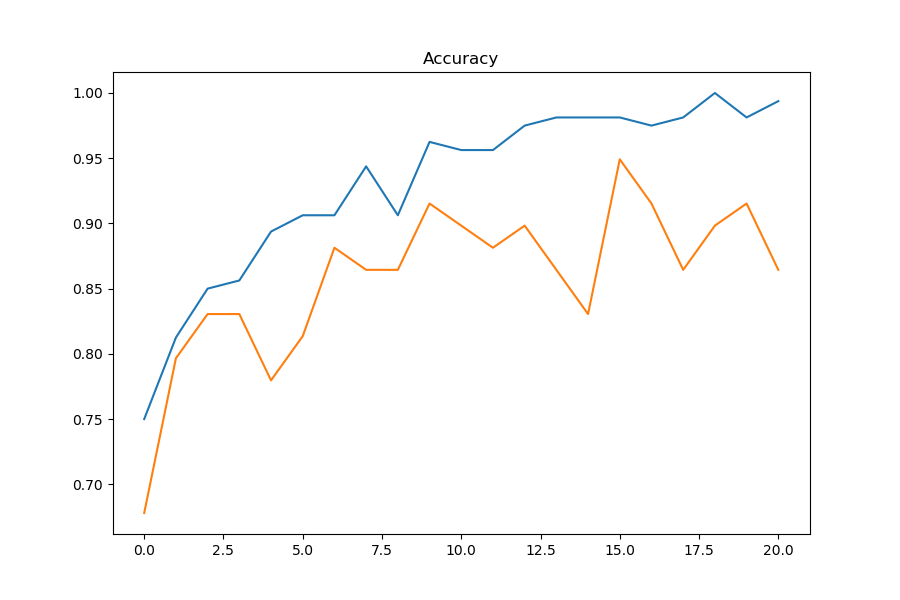

In [25]:
if train:
    plt.figure(figsize=(9, 6))
    plt.title("Loss")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.savefig('loss.png')
    
    plt.figure(figsize=(9, 6))
    plt.title("Accuracy")
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.savefig('acc.png')

# Results

## Load model

In [14]:
import IPython.display as ipd

from sklearn.metrics import roc_curve, auc

from microfaune.audio import load_wav
import librosa.display

In [15]:
if not train:
    #model.load_weights("model_weights-20190919_220113.h5")
    model.load_weights("model_weights-20200526_083126.h5")

In [16]:
wav_files = {os.path.basename(f)[:-4]: f for f in glob(os.path.join(datasets_dir, "*/wav/*.wav"))}

## Evaluation on validation dataset

In [17]:
%%time
scores, local_scores = dual_model.predict(X_test)

Wall time: 4.47 s


In [18]:
Y_hat = scores.squeeze() > 0.5
print(f"Accuracy: {np.mean(Y_hat == Y_test)*100:.2f}")

Accuracy: 86.44


In [19]:
fpr, tpr, sc = roc_curve(Y_test, scores)
print(f"Area under ROC curve: {auc(fpr, tpr):f}")

Area under ROC curve: 0.967105


In [20]:
plt.figure(figsize=(9, 6))
plt.plot(1-fpr, tpr)
plt.title("Precision/Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.savefig("imgs/PR_curve.png")

<IPython.core.display.Javascript object>

In [21]:
success = np.where(Y_hat == Y_test)[0]
errors = np.where(Y_hat != Y_test)[0]

In [22]:
def check_result(uid, x, y, pred_score, y_hat_time, wav_files=wav_files):
    wav_file = wav_files[uid]
    sr, audio = load_wav(wav_file)
    plt.figure(figsize=(9, 6))
    label_dict = {0: "Negative", 1: "Positive"}
    plt.suptitle(f"UID: '{uid}', {label_dict[y]} example, predicted score: {pred_score[0]:.2f}")

    plt.subplot(3, 1, 1)
    plt.title("Audio wave")
    librosa.display.waveplot(audio, sr)

    plt.subplot(3, 1, 2)
    plt.title("MEL spectrogram")
    librosa.display.specshow(np.rot90(x.squeeze(), -1))

    plt.subplot(3, 1, 3)
    plt.title("Local prediction")
    ax = plt.gca()
    ax.set_xlim(0, x.shape[0])
    ax.set_ylim(-0.05, 1.05)
    plt.plot(y_hat_time)
    return ipd.Audio(wav_file)
    

## success

In [23]:
ind = success[2]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

<IPython.core.display.Javascript object>

In [24]:
ind = success[]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_success.png")
reader

SyntaxError: invalid syntax (<ipython-input-24-212c5139bcd0>, line 1)

In [ ]:
ind = success[15]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
ind = success[99]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
ind = 89
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/negative_success.png")
reader

In [ ]:
ind = 565
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

## errors

In [ ]:
ind = errors[1]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/negative_error.png")
reader

In [ ]:
ind = errors[5]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_error.png")
reader

## labelling errors?

In [ ]:
ind = errors[12]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
# false error
ind = 105
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/labelling_error.png")
reader

## Test on other datasets

### BirdVox